# Explore LHC dataset

In [6]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
import logging
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

sys.path.append("../../")
from experiments.datasets import WBFLoader, WBF40DLoader
import plot_settings as ps


In [7]:
ps.setup()

## Get data

In [11]:
n = 10000

In [12]:
sim = WBFLoader()
sim40d = WBF40DLoader()

In [17]:
x, params = sim.load_dataset(train=True, dataset_dir="../data/samples/lhc", numpy=True, limit_samplesize=n)
x_ = sim._preprocess(x, inverse=True)
x_noise = np.random.normal(size=x.shape)

x40d, _ = sim40d.load_dataset(train=True, dataset_dir="../data/samples/lhc40d", numpy=True, limit_samplesize=n)
x40d_noise = np.random.normal(size=x40d.shape)
x40d_test, _ = sim40d.load_dataset(train=False, dataset_dir="../data/samples/lhc40d", numpy=True, limit_samplesize=n)
x40d_test2, _ = sim40d.load_dataset(train=False, dataset_dir="../data/samples/lhc40d", numpy=True, limit_samplesize=n, true_param_id=2)
x40d_mfmf = np.load("../data/results/mf_14_lhc40d_sequential_scandal_may_samples.npy")
x40d_mfmf2 = np.load("../data/results/mf_14_lhc40d_sequential_scandal_may_samples_trueparam2.npy")
x40d_af = np.load("../data/results/flow_14_lhc40d_scandal_may_samples.npy")
x40d_af2 = np.load("../data/results/flow_14_lhc40d_scandal_may_samples_trueparam2.npy")


10:23 experiments.datasets.collider  INFO    Only using 10000 of 1000000 available samples
10:23 experiments.datasets.collider  INFO    Only using 10000 of 1000000 available samples
10:23 experiments.datasets.collider  INFO    Only using 10000 of 10000 available samples
10:23 experiments.datasets.collider  INFO    Only using 10000 of 10000 available samples


## PCA

In [9]:
pca = PCA(n_components=48)
pca.fit(x)

explained_var = pca.explained_variance_ratio_


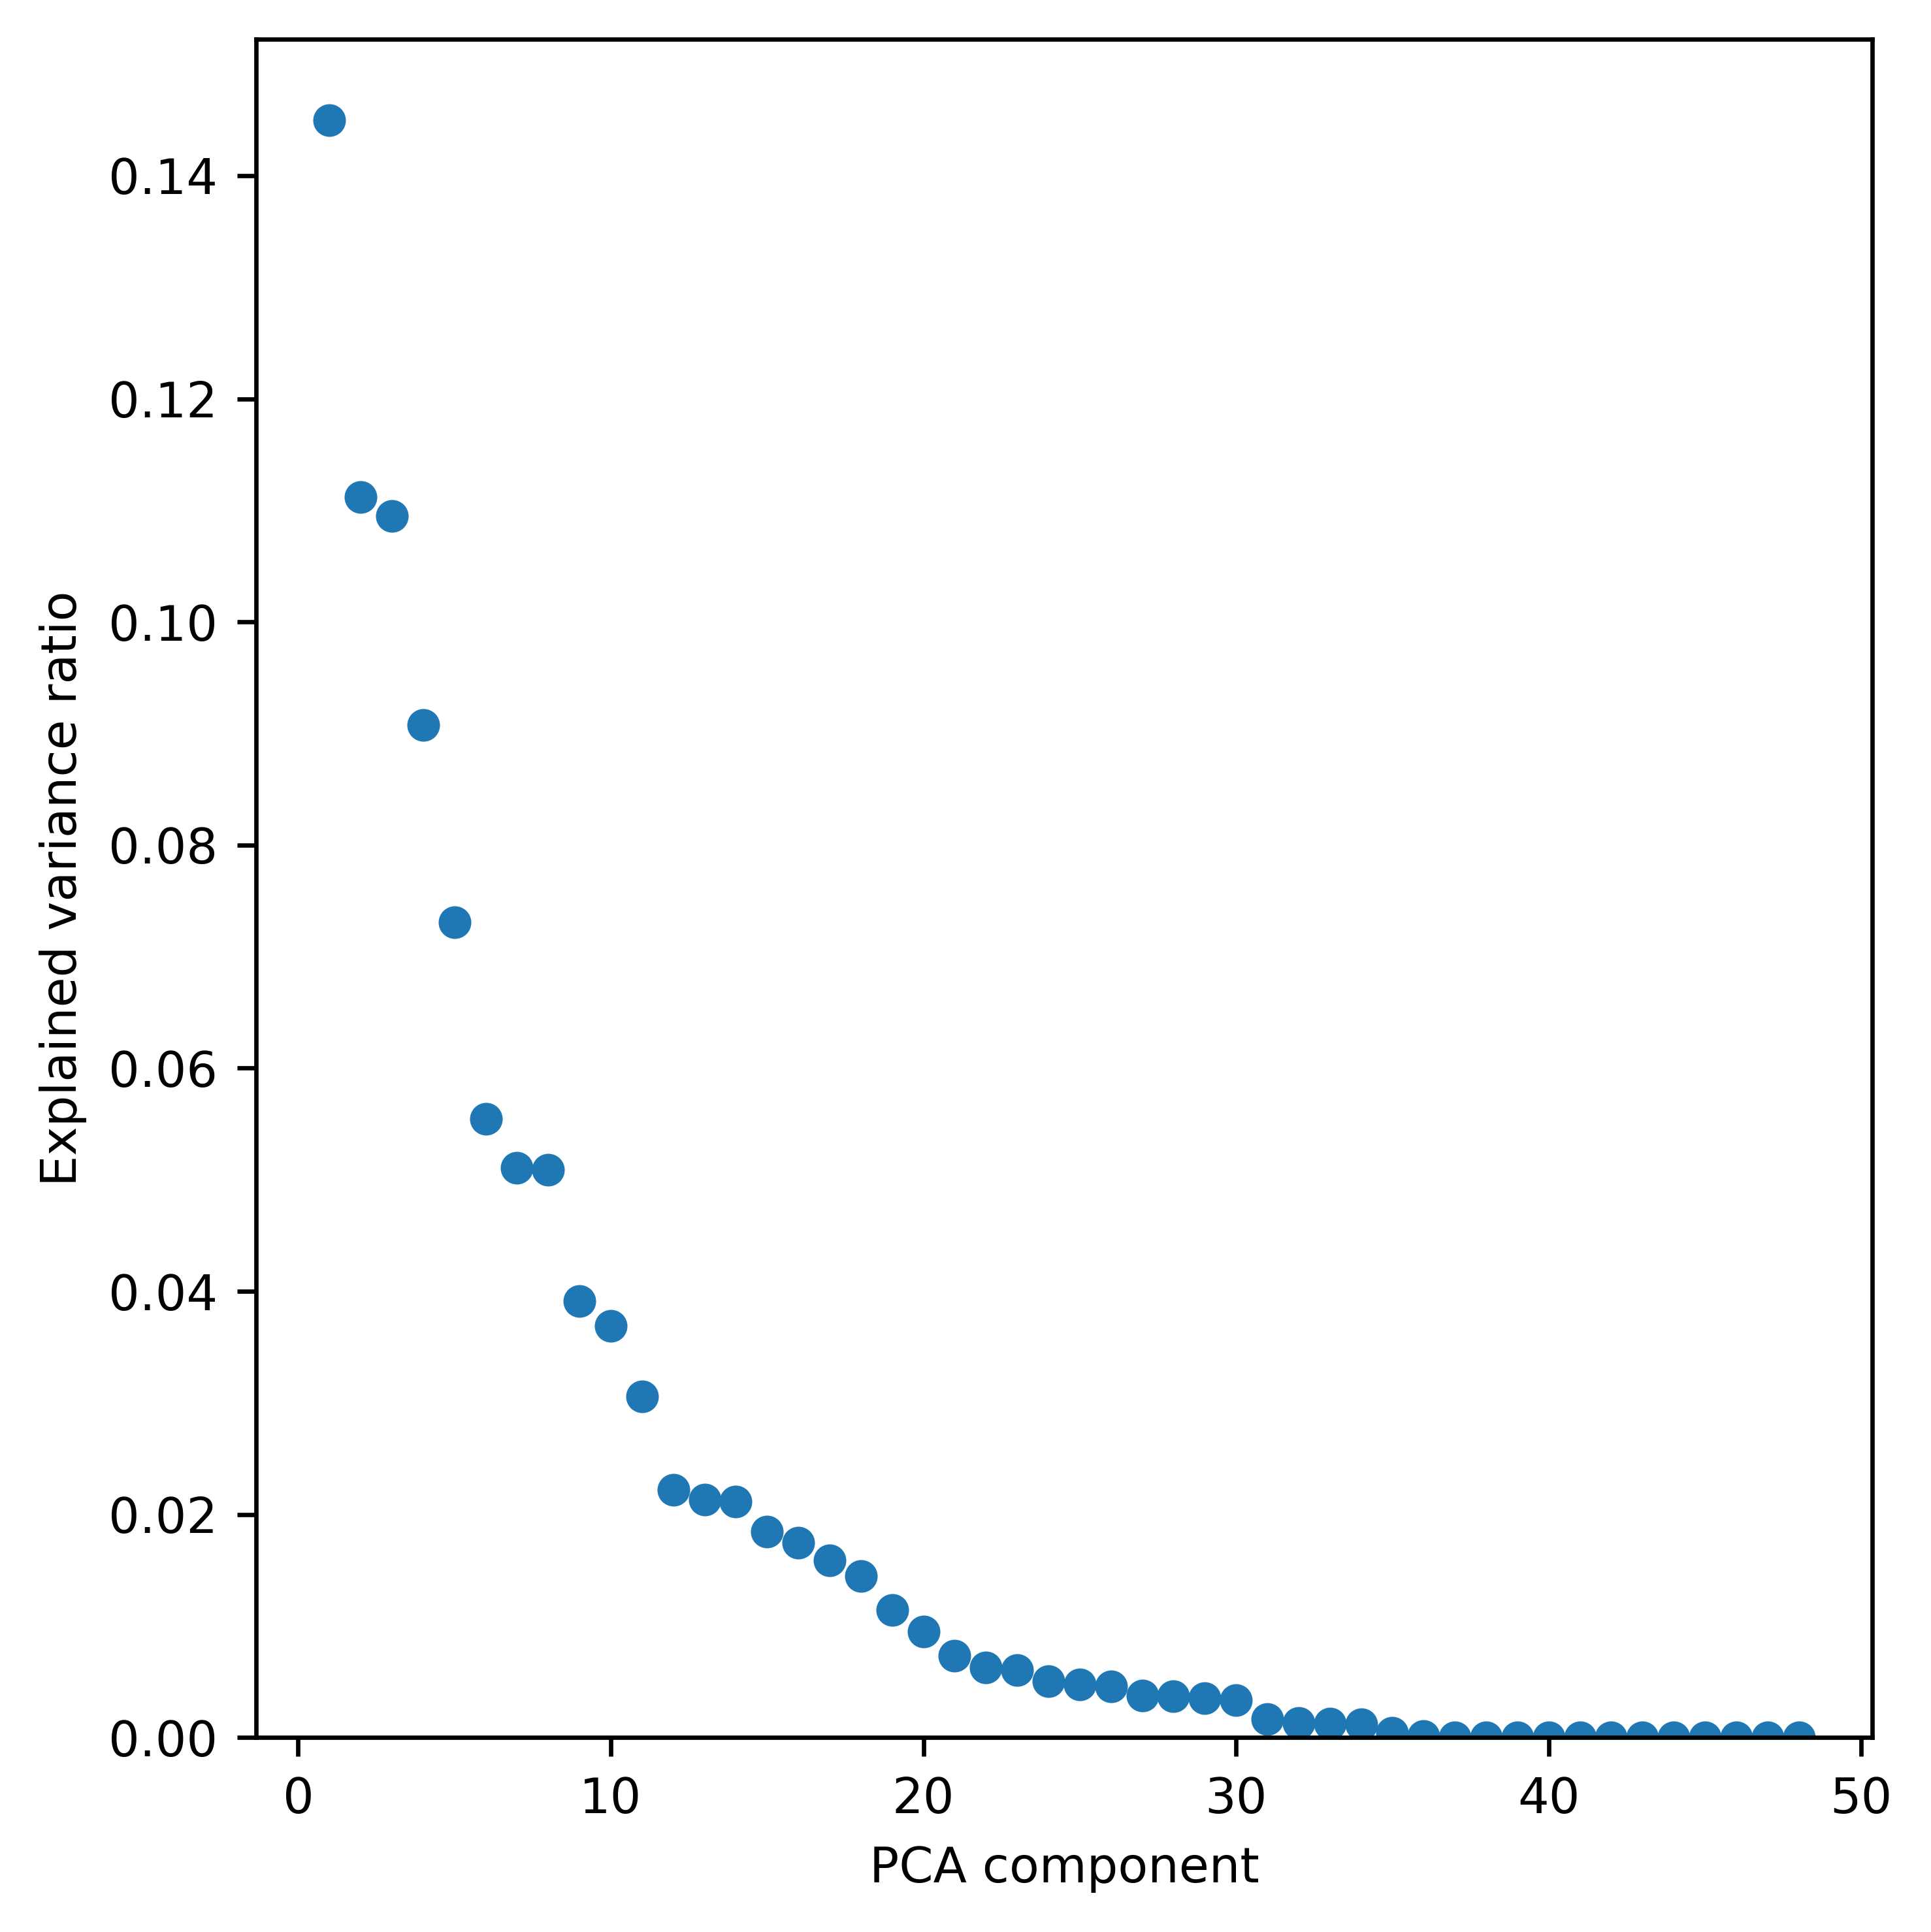

In [10]:
plt.figure(figsize=(5,5))

plt.plot(np.arange(1, 48.5), explained_var, ls=" ", marker="o", ms=5.)

plt.ylim(0.,None)
plt.xlabel("PCA component")
plt.ylabel("Explained variance ratio")

plt.tight_layout()
plt.show()


## t-SNE

In [ ]:
x_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit_transform(x)
noise_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit_transform(x_noise)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.295s...


In [ ]:
x_reshuffled = np.copy(x)
idx = np.random.rand(*x_reshuffled.shape).argsort(0)
x_reshuffled = x_reshuffled[idx, np.arange(x_reshuffled.shape[1])]

x_reshuffled_tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000).fit_transform(x_reshuffled)


In [ ]:
plt.figure(figsize=(12, 4))

ax = plt.subplot(1,3,1)
plt.scatter(
    x_tsne[x[:,16]>0.][:, 0],
    x_tsne[x[:,16]>0.][:, 1],
    s=12.0,
    alpha=0.15,
    c="C0"
)
plt.scatter(
    x_tsne[x[:,16]<0.][:, 0],
    x_tsne[x[:,16]<0.][:, 1],
    s=12.0,
    alpha=0.15,
    c="C1"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

ax = plt.subplot(1,3,2)
plt.scatter(
    x_reshuffled_tsne[:, 0],
    x_reshuffled_tsne[:, 1],
    s=12.0,
    alpha=0.15,
    c="C2"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

ax = plt.subplot(1,3,3)
plt.scatter(
    noise_tsne[:, 0],
    noise_tsne[:, 1],
    s=12.0,
    alpha=0.15,
    c="C4"
)
plt.xlabel("t-SNE component 0")
plt.ylabel("t-SNE component 1")

plt.tight_layout()
plt.savefig("../figures/lhc_tsne.pdf")

In [ ]:
npanels = 48
ncols = 6
nrows = (npanels - 1) // ncols + 1

plt.figure(figsize=(ncols * 3, nrows * 3))

for i in range(npanels):
    ax = plt.subplot(nrows,ncols,i+1)
    plt.scatter(
        x_tsne[x[:,i]>0.][:250, 0],
        x_tsne[x[:,i]>0.][:250, 1],
        s=12.0,
        c="C0"
    )
    plt.scatter(
        x_tsne[x[:,i]<0.][:250, 0],
        x_tsne[x[:,i]<0.][:250, 1],
        s=12.0,
        c="C1"
    )
    plt.title("Feature {}".format(i))
    plt.xlabel("t-SNE 0")
    plt.ylabel("t-SNE 1")

plt.tight_layout()
plt.savefig("../figures/lhc_tsne_features.pdf")

## Determine weights for individual closure tests

In [ ]:
random_closure_tests = np.mean(sim._closure_tests(x_noise), axis=1)
CLOSURE_TEST_WEIGHTS = 1. / random_closure_tests
print(", ".join([str(w) for w in CLOSURE_TEST_WEIGHTS]))

## Closure test vs noise

In [ ]:
np.mean(sim.distance_from_manifold(x)), np.mean(sim.distance_from_manifold(x_noise))

In [ ]:
np.mean(sim40d.distance_from_manifold(x40d)), np.mean(sim40d.distance_from_manifold(x40d_noise))

In [ ]:
noises = np.geomspace(1.e-9, 1., 100)

closure = []

for noise in noises:
    closure.append(np.mean(sim.distance_from_manifold(x + noise * np.random.normal(size=x.shape))))

In [ ]:
plt.figure(figsize=(5,5))

plt.plot(noises, closure)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Noise")
plt.ylabel("Mean closure")

plt.tight_layout()
plt.savefig("../figures/lhc_closure_vs_noise.pdf")


## Marginals

In [23]:
ncols = 7
nrows = 6

fig = plt.figure(figsize=(3*ncols, 3*nrows))

for i in range(40):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.hist(x40d[:,i], range=(-5,5), bins=50, density=True, color="0.8")
    
    plt.hist(
        x40d_test[:,i], range=(-5,5), bins=50, density=True,
        histtype="step", color="black", ls="-", lw=1.5, label="Simulator"
    )
    plt.hist(
        x40d_af[:,i], range=(-5,5), bins=50, density=True,
        histtype="step", color=[ps.COLOR_AF], ls="-", lw=1.5, label="AF"
    )
    plt.hist(
        x40d_mfmf[:,i], range=(-5,5), bins=50, density=True,
        histtype="step", color=[ps.COLOR_FLMA], ls="-", lw=1.5, label="MFMF"
    )
    
#     plt.hist(
#         x40d_test2[:,i], range=(-5,5), bins=50, density=True,
#         histtype="step", color="black", ls="--", lw=1.5
#     )
#     plt.hist(
#         x40d_af2[:,i], range=(-5,5), bins=50, density=True,
#         histtype="step", color=[ps.COLOR_AF], ls="--", lw=1.5
#     )
#     plt.hist(
#         x40d_mfmf2[:,i], range=(-5,5), bins=50, density=True,
#         histtype="step", color=[ps.COLOR_FLMA], ls="--", lw=1.5
#     )
    
    if i == 0:
        plt.legend()
    
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
plt.tight_layout()
plt.savefig("../figures/lhc_features_histos.pdf")


## Scatter plots of features

In [ ]:
features = list(range(40))
n = len(features)
m = 100

fig = plt.figure(figsize=(1*(n-1), 1*(n-1)))
for ip, i in enumerate(features[1:]):
    for jp in range(ip):
        j = features[jp]
        ax = plt.subplot(n-1, n-1, ip*(n-1) + jp + 1)
        plt.scatter(x40d[:m,j], x40d[:m,i], s=2., c=["0.5"], rasterized=True)
        plt.scatter(x40d_test[:m,j], x40d_test[:m,i], s=2., c=["black"], rasterized=True)
        plt.scatter(x40d_af[:m,j], x40d_af[:m,i], s=2., c=[ps.COLOR_AF], rasterized=True)
        plt.scatter(x40d_mfmf[:m,j], x40d_mfmf[:m,i], s=2., c=[ps.COLOR_FLMA], rasterized=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.xlim(-2.5,2.5)
        plt.ylim(-2.5,2.5)
        
        if ip == n - 2:
            plt.xlabel(str(j))
        if jp == 0:
            plt.ylabel(str(i))
        
plt.tight_layout()
plt.savefig("../figures/lhc_features_scatter.pdf")
